In [1]:
import numpy as np
import pandas as pd

On se connecte à la base de données

In [2]:
from db_utils import get_db_engine

# Obtenir le moteur de base de données
engine = get_db_engine()

On charge les fichiers sources


In [3]:
# Charger les fichiers sources
file1 = 'data\\ObesityDataSet_raw_and_data_sinthetic.csv'
file2 = 'data\\lifestyle_sustainability_data.csv'
file3 = 'data\\DietSurvey_toJson.json'

# Charger les fichiers dans des DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_json(file3)


Création du dataframe

In [4]:
# food_habits1 - df1
food_habits1 = df1[['NCP', 'FCVC', 'FAVC', 'SCC', 'CH2O']].rename(
    columns={
        'NCP': 'nbr_meal_day',
        'FCVC': 'vegetable_con',
        'CH2O': 'water_con'
    }
)

# Combiner FAVC et SCC en une seule colonne 'fat_con'
food_habits1['fat_con'] = df1['FAVC'] + " & " + df1['SCC']

# Supprimer les colonnes 'FAVC' et 'SCC' après leur utilisation
food_habits1 = food_habits1.drop(columns=['FAVC', 'SCC'])

food_habits1['takeout'] = None  # Pas de colonne correspondante dans df1
food_habits1['alcohol_con'] = None  # Pas de colonne correspondante dans df1
food_habits1['monitor_cal'] = None  # Pas de colonne correspondante dans df1

print("food_habits1 préparé.")

# food_habits2 - df2
food_habits2 = df2[['LocalFoodFrequency']].rename(columns={'LocalFoodFrequency': 'takeout'})
food_habits2['nbr_meal_day'] = None
food_habits2['vegetable_con'] = None
food_habits2['fat_con'] = None
food_habits2['water_con'] = None
food_habits2['alcohol_con'] = None
food_habits2['monitor_cal'] = None

print("food_habits2 préparé.")

# food_habits3 - df3
food_habits3 = df3[
    [
        "How many times a week do you order-in or go out to eat?",
        "Choose all that apply: [I consult a nutritionist/dietician]",
        "What is your weekly food intake frequency of the following food categories: [Fresh vegetables]",
        "What is your weekly food intake frequency of the following food categories: [Salty foods]",
        "Choose all that apply: [I cook my own meals]",
        "What is your water consumption like (in a day, 1 cup=250ml approx)",
        "How frequently do you consume these beverages [Alcoholic Beverages]"
    ]
].rename(
    columns={
        "How many times a week do you order-in or go out to eat?": "nbr_meal_day",
        "Choose all that apply: [I consult a nutritionist/dietician]": "monitor_cal",
        "What is your weekly food intake frequency of the following food categories: [Fresh vegetables]": "vegetable_con",
        "What is your weekly food intake frequency of the following food categories: [Salty foods]": "fat_con",
        "Choose all that apply: [I cook my own meals]": "takeout",
        "What is your water consumption like (in a day, 1 cup=250ml approx)": "water_con",
        "How frequently do you consume these beverages [Alcoholic Beverages]": "alcohol_con"
    }
)

print("food_habits3 préparé.")


food_habits1 préparé.
food_habits2 préparé.
food_habits3 préparé.


Transormation des données

1. vegetable_con

In [5]:
print(food_habits1['vegetable_con'].unique())



[2.       3.       1.       2.450218 2.880161 2.00876  2.596579 2.591439
 2.392665 1.123939 2.027574 2.658112 2.88626  2.714447 2.750715 1.4925
 2.205439 2.059138 2.310423 2.823179 2.052932 2.596364 2.767731 2.815157
 2.737762 2.568063 2.524428 2.971574 1.0816   1.270448 1.344854 2.959658
 2.725282 2.844607 2.44004  2.432302 2.592247 2.449267 2.929889 2.015258
 1.031149 1.592183 1.21498  1.522001 2.703436 2.362918 2.14084  2.5596
 2.336044 1.813234 2.724285 2.71897  1.133844 1.757466 2.979383 2.204914
 2.927218 2.88853  2.890535 2.530066 2.241606 1.003566 2.652779 2.897899
 2.483979 2.945967 2.478891 2.784464 1.005578 2.938031 2.842102 1.889199
 2.943749 2.33998  1.950742 2.277436 2.371338 2.984425 2.977018 2.663421
 2.753752 2.318355 2.594653 2.886157 2.967853 2.619835 1.053534 2.530233
 2.8813   2.824559 2.762325 2.070964 2.68601  2.794197 2.720701 2.880792
 2.674431 2.55996  1.212908 1.140615 2.562409 2.004146 2.690754 2.051283
 2.19005  2.21498  2.91548  2.708965 2.853513 2.580872 

In [6]:
# Fonction de catégorisation pour "vegetable_con"
def categorize_vegetable_con(value):
    if pd.isna(value):
        return None
    elif value <= 1:
        return "Few times a week"
    elif value <= 2:
        return "Once a day"
    elif value <= 2.5:
        return "Often"
    elif value <= 3:
        return "In every meal"
    else:
        return "Several times a day"

# Appliquer la fonction de catégorisation à la colonne 'vegetable_con' dans food_habits1
food_habits1['vegetable_con'] = food_habits1['vegetable_con'].apply(categorize_vegetable_con)


In [7]:
print(food_habits1['vegetable_con'].unique())


['Once a day' 'In every meal' 'Few times a week' 'Often']


2. fat_con

In [8]:
# Si ton dataframe est df3, tu peux utiliser :
unique_fat_con_values = food_habits3 ['fat_con'].unique()

# Afficher les valeurs uniques de 'fat_con'
print(unique_fat_con_values)


['Once a day' 'Often' 'Several times a day' 'Few times a week'
 'Once a month' 'In every meal' 'Never']


In [9]:
# Dictionnaire de correspondance pour mapper les valeurs de df1['fat_con'] aux valeurs de food_habits['fat_con']
mapping_fat_con = {
    'no & no': 'Never',
    'no & yes': 'Few times a week',
    'yes & no': 'Once a day',
    'yes & yes': 'Several times a day',
}

# Appliquer cette correspondance à food_habits1['fat_con']
food_habits1['fat_con'] = food_habits1['fat_con'].map(mapping_fat_con).fillna(food_habits1['fat_con'])


3. water_con

In [10]:
# Vérifier les valeurs uniques de la colonne 'water_con' dans food_habits3
food_habits3['water_con'].unique()


array(['More than 15 cups', '11-14 cups', '7-10 cups', '4-6 cups',
       'Less than 3 cups'], dtype=object)

In [11]:
# Fonction pour convertir la note en catégorie 'water_con'
def categorize_water_con(note):
    if note >= 2.7:
        return 'More than 15 cups'
    elif note >= 2.3:
        return '11-14 cups'
    elif note >= 1.7:
        return '7-10 cups'
    elif note >= 1.0:
        return '4-6 cups'
    else:
        return 'Less than 3 cups'

# Appliquer la fonction à la colonne 'water_con' de food_habits1
food_habits1['water_con'] = food_habits1['water_con'].apply(categorize_water_con)

In [12]:
# Concatenation des DataFrames préparés
food_habits = pd.concat([food_habits1, food_habits2, food_habits3], ignore_index=True)
print("Food habits combiné.")

Food habits combiné.


C:\Users\user\AppData\Local\Temp\ipykernel_3984\2478920308.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  food_habits = pd.concat([food_habits1, food_habits2, food_habits3], ignore_index=True)


In [13]:
# Fonction pour générer un nombre aléatoire dans les plages de chaque catégorie
def randomize_water_con(value):
    if value == 'More than 15 cups':
        return np.random.randint(15, 25)  # Entre 15 et 20
    elif value == '11-14 cups':
        return np.random.randint(11, 14)  # Entre 11 et 14
    elif value == '7-10 cups':
        return np.random.randint(7, 10)   # Entre 7 et 10
    elif value == '4-6 cups':
        return np.random.randint(4, 6)    # Entre 4 et 6
    elif value == 'Less than 3 cups':
        return np.random.randint(0, 3)    # Entre 0 et 3
    else:
        return value

# Appliquer la fonction à la colonne 'water_con' de food_habits
food_habits['water_con'] = food_habits['water_con'].apply(randomize_water_con)


In [14]:
food_habits

,nbr_meal_day,vegetable_con,water_con,fat_con,takeout,alcohol_con,monitor_cal
0,3.0,Once a day,7.0,Never,None,None,None
1,3.0,In every meal,21.0,Few times a week,None,None,None
2,3.0,Once a day,7.0,Never,None,None,None
3,3.0,In every meal,8.0,Never,None,None,None
4,1.0,Once a day,9.0,Never,None,None,None
...,...,...,...,...,...,...,...
2683,2.0,Several times a day,7.0,Few times a week,Never,Few times a week,Never
2684,3.0,Several times a day,24.0,Few times a week,Never,Few times a week,Never
2685,3.0,In every meal,7.0,Few times a week,Sometimes,Never,Never
2686,3.0,Once a day,4.0,Few times a week,Rarely,Few times a week,Never


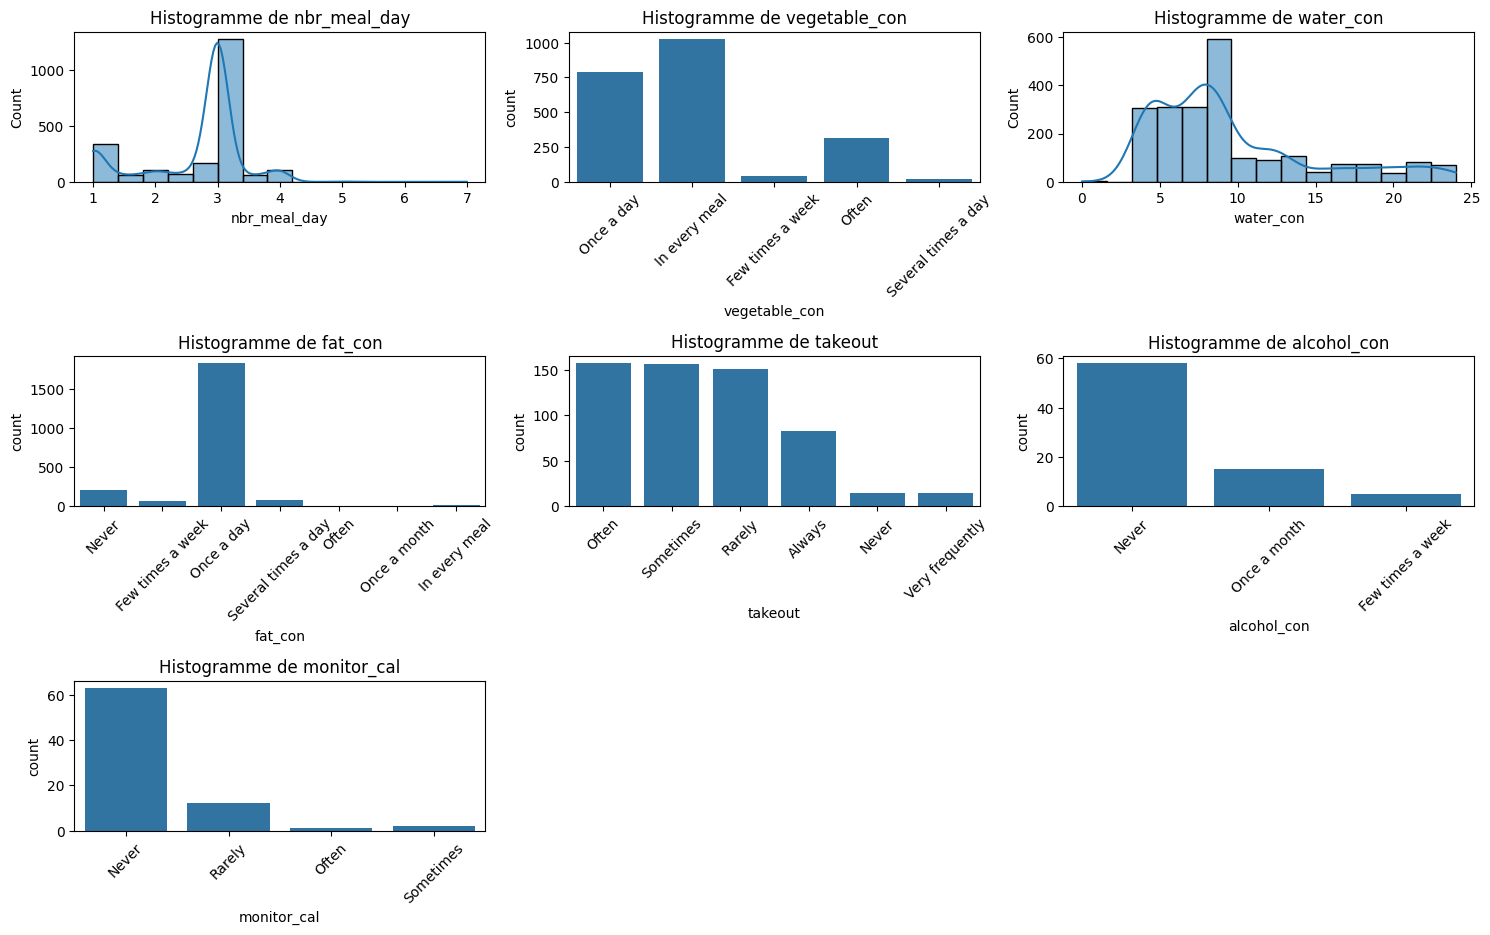

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Définir la taille de la figure pour afficher plusieurs graphes
plt.figure(figsize=(15, 15))

# Loop à travers chaque colonne du DataFrame pour créer un histogramme
for i, column in enumerate(food_habits.columns):
    plt.subplot(5, 3, i + 1)  # 5 lignes, 3 colonnes pour organiser les graphiques
    if food_habits[column].dtype == 'object':  # Si la colonne est catégorielle
        sns.countplot(data=food_habits, x=column)
        plt.title(f'Histogramme de {column}')
        plt.xticks(rotation=45)
    else:  # Si la colonne est numérique
        sns.histplot(food_habits[column], kde=True, bins=15)
        plt.title(f'Histogramme de {column}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les graphiques

# Afficher tous les graphiques
plt.show()
